In [6]:
from tkinter import *
import time
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

# This function takes 2 arguments, 
#   - an optional keras model,
#   - Canvas Width allows user to set the pixel height and width of the drawing box
#
#  The function returns a 28*28 matrix of  pixel values made from the canvas drawing
#  if a keras model is also provided then the function will plot prediction results too

def DrawMyOwnNumbers(Kerasmodel=None,CanvasWidth=200):
    DrawnOutMatrix=0
    width=CanvasWidth
    white = (255, 255, 255)
    black = (0, 0, 0)

    b1 = "up"
    xold, yold = None, None    

    def b1down(event):
        nonlocal b1
        b1 = "down"           

    def b1up(event):
        nonlocal b1, xold, yold
        b1 = "up"
        xold = None
        yold = None
    def motion(event):
            if b1 == "down":
                nonlocal xold, yold
                if xold is not None and yold is not None:
                    event.widget.create_line(xold,yold,event.x,event.y)
                    draw.line([xold,yold,event.x,event.y], black)
                xold = event.x
                yold = event.y
    root = Tk()

    drawing_area = Canvas(root,width=width,height=width)
    image1 = Image.new("RGB", (width, width), white)
    draw = ImageDraw.Draw(image1)
    drawing_area.pack()
    drawing_area.bind("<Motion>", motion)
    drawing_area.bind("<ButtonPress-1>", b1down)
    drawing_area.bind("<ButtonRelease-1>", b1up)
    
    def handle_click():
        nonlocal DrawnOutMatrix
        nonlocal root
        root.destroy()
        %matplotlib inline


        filename = "4my_drawing.bmp"
        image1.save(filename)
        II=np.asarray(mpimg.imread(filename))
        II=np.apply_along_axis(np.min,2,II)
        

        data=np.asarray([[i,j] for i in range(width) for j in range(width) if II[j,i]==0]).astype('float64')
        datax=data[:,0]
        datay=data[:,1]
        
        # centre and scale the pixels
        datax -= np.mean(datax)
        datay -= np.mean(datay)
        scaling = np.max(np.abs([datax.min(),datax.max(),datay.min(),datay.max()]))
        datax *= 1/scaling
        datay *= 1/scaling
      
        posn = np.linspace(-1.2,1.2, 28)
        sx = -0.5*(1/0.06)**2
        def kde(x,y):
            return(np.min([np.sum(np.exp(sx*((x-datax)**2+(y-datay)**2))),5]))

        output=np.asarray([[kde(x,y) for x in posn] for y in posn])
        output=output/output.max()
        output1=np.asarray([[[ [output[j,i]] for i in np.arange(28)] for j in np.arange(28)]])
        DrawnOutMatrix=output1[0,:,:,0]
        
        if Kerasmodel:
            p= Kerasmodel.predict_proba(output1,verbose=1==2)[0]

            f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
            ax1.imshow(255-II,cmap='Greys')

            def PlotMnist(inn,ax):
                ax.imshow(inn[0,:,:,0],cmap='Greys')

            PlotMnist(output1,ax2)
            ax3.bar(np.arange(10),p,0.8,color='g')


    Button(root, text='classify!', command=handle_click).pack()
    root.mainloop()
    return DrawnOutMatrix

In [8]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/4
469/469 [==============================] - 1s 2ms/step - loss: 2.2767 - accuracy: 0.1323 - val_loss: 2.2506 - val_accuracy: 0.1461
Epoch 2/4
469/469 [==============================] - 1s 2ms/step - loss: 2.2246 - accuracy: 0.1752 - val_loss: 2.1975 - val_accuracy: 0.1953
Epoch 3/4
469/469 [==============================] - 1s 2ms/step - loss: 2.1732 - accuracy: 0.2237 - val_loss: 2.1449 - val_accuracy: 0.2443
Epoch 4/4
469/469 [==============================] - 1s 2ms/step - loss: 2.1217 - accuracy: 0.2724 - val_loss: 2.0918 - val_accuracy: 0.2966
Test loss: 2.0918054580688477
Test accuracy: 0.29660001397132874


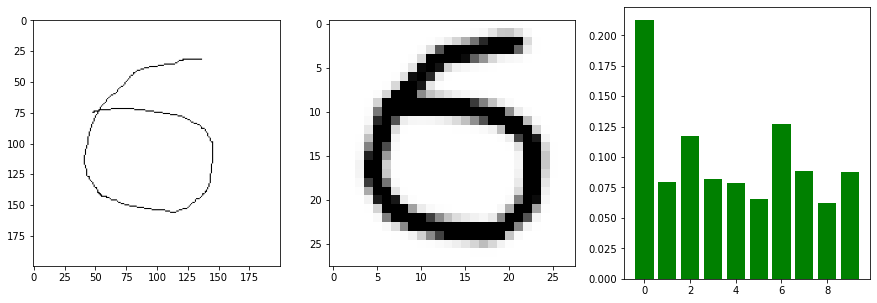

In [9]:
A=DrawMyOwnNumbers(model)